# Анализ воронки продаж и применение А/А/В-тестирования.
**Цель исследования** — изучение поведения пользователей мобильного приложения, анализ воронки продаж и проведение A/A/B-эксперимента для определения лучшего варианта шрифтов в приложении. \
**Ход исследования**: Работа пройдёт в несколько этапов:
* Подготовка и предобработка данных
* Анализ данных
* Изучение воронки событий
* Изучение результатов эксперимента

### Подготовка и предобработка данных

Для начала импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from scipy import stats as st
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import plotly.graph_objects as go
import warnings
import math as mth
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

Загрузим датасет из CSV-файла и выведем общую информацию о нём:

In [2]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep="\t")

In [3]:
logs.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Для удобства приведём названия столбцов к "змеиному регистру":

In [5]:
logs.columns = ('event_name', 'device_id_hash', 'event_timestamp', 'exp_id')

In [6]:
logs.head(5)

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Проверим датасет на наличие пропусков и дубликатов:

In [7]:
logs.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

In [8]:
logs.duplicated().sum()

413

Видим, что в датасете есть дубликаты. Удалим их и проверим на пропуски снова:

In [9]:
logs = logs.drop_duplicates().reset_index(drop=True)

In [10]:
logs.duplicated().sum()

0

Видим, что столбец `event_timestamp` представлен в формате временных меток Unix. Для удобства и дальнейшего анализа датасета создадим столбцы `event_time` и `event_date`, в которых будут храниться, соответственно, значения даты и времени и только даты события, приведенные к формату `datetime`:

In [11]:
logs['event_time'] = pd.to_datetime(logs['event_timestamp'], unit='s')
logs['event_date'] = pd.to_datetime(logs['event_time'].dt.date)

In [12]:
logs.head(5)

,event_name,device_id_hash,event_timestamp,exp_id,event_time,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


#### Вывод.
* Названия столбцов таблиц приведены к единому стилю
* Пропуски и дубликаты в датасете отсутствуют
* Добавлены новые столбцы с датой события, преобразованные в удобный для анализа формат.

Таким образом, выполнена предобработка данных и датасет готов к дальнейшему анализу.

### Изучение и проверка данных

Определим, сколько всего событий представлено в датасете:

In [13]:
event_count = logs['event_name'].count()
print('Количество событий в логе:', event_count)

Количество событий в логе: 243713


Определим, сколько всего пользователей:

In [14]:
users_count = logs['device_id_hash'].nunique()
print("Количество уникальных пользователей:", users_count)

Количество уникальных пользователей: 7551


In [15]:
print('Событий в среднем на пользователя:', round(event_count / users_count))

Событий в среднем на пользователя: 32


Проверим, данными за какой период мы располагаем. Для этого определим минимальную и максимальную дату в столбце `event_date`:

In [16]:
print('Минимальное время:', logs['event_date'].min())
print('Максимальное время:', logs['event_date'].max())

Минимальное время: 2019-07-25 00:00:00
Максимальное время: 2019-08-07 00:00:00


Построим гистограмму по столбцу `event_time` с датой и временем:

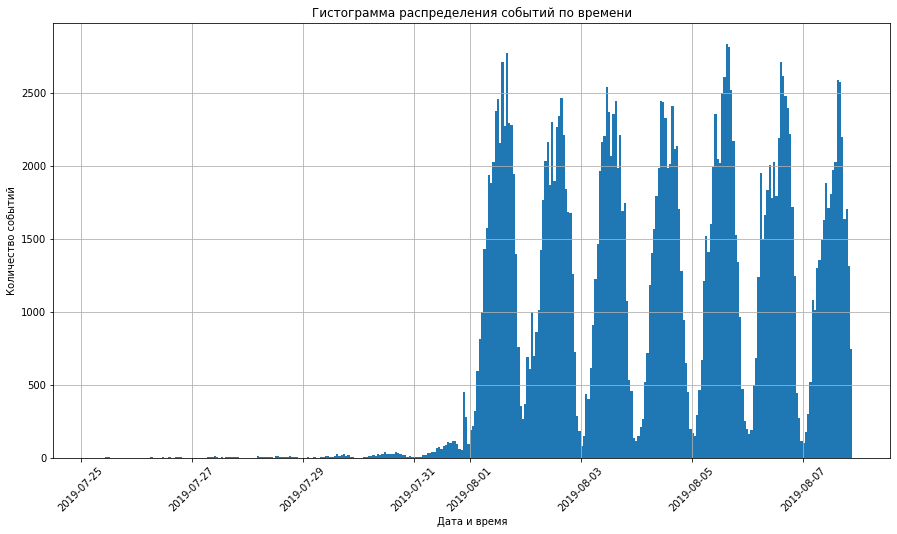

In [17]:
# установим размер графика
plt.figure(figsize=(15,8))

# построим гистограмму
logs['event_time'].hist(bins=14*24)

# добавим подписи осей
plt.xlabel('Дата и время')
plt.ylabel('Количество событий')

# добавим заголовок
plt.title('Гистограмма распределения событий по времени')

# повернем подписи по оси x на 45 градусов
plt.xticks(rotation=45)

# покажем график
plt.show()

Можем заметить, что преобладающее количество событий сосредоточено в период между 1 и 7 августа. Таким образом, чтобы получить корректную картину исследования, отбросим старые и неполные данные и перезапишем их в новую переменную:

In [18]:
logs_filtered = logs.query("event_date >= '2019-08-01'")

Теперь посмотрим, сколько событий и пользователей мы потеряли, отбросив старые данные:

In [19]:
event_count_filtered = logs_filtered['event_name'].count()
print('Количество событий в логе:', event_count_filtered)
users_count_filtered = logs_filtered['device_id_hash'].nunique()
print("Количество уникальных пользователей:", users_count_filtered)
print('Событий в среднем на пользователя:', round(event_count_filtered / users_count_filtered))
print('Разница в количестве событий между отфильтрованным и исходным датасетом составила', round((event_count - event_count_filtered)/event_count*100, 2), '%')
print('Разница в количестве уникальных пользователей между отфильтрованным и исходным датасетом составила', round((users_count - users_count_filtered)/users_count*100, 2), '%')

Количество событий в логе: 240887
Количество уникальных пользователей: 7534
Событий в среднем на пользователя: 32
Разница в количестве событий между отфильтрованным и исходным датасетом составила 1.16 %
Разница в количестве уникальных пользователей между отфильтрованным и исходным датасетом составила 0.23 %


Таким образом, отфильтровав и отбросив неактуальные данные, мы потеряли чуть больше одного процента событий, что не является значимой величиной и не способно исказить дальнейший анализ.

Наконец, проверим наличие пользователей во всех трёх экспериментальных группах:

In [20]:
logs_filtered.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

Видим, что пользователи представлены во всех группах и их количество распределено почти равномерно.

#### Вывод
* Преобладающее количество событий сосредоточено в период между 1 и 7 августа
* Отфильтровав и актуализировав данные, мы потеряли чуть больше одного процента событий, что не способно исказить дальнейший анализ.
* Пользователи представлены во всех группах, количество пользователей в каждой из групп примерно одинаковое.

### Изучение воронки событий

Посмотрим, какие события есть в логах, как часто они встречаются и отсортируем события по частоте:

In [21]:
logs_filtered['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Самое распространенное событие — MainScreenAppear (более 117 тыс.), оно возникает когда пользователь запускает приложение и попадает на главный экран. \
Реже всего встречалось событие Tutorial (1005 раз), которое обозначает этап обучения, который пользователь должен пройти, чтобы начать использовать продукт.

Теперь посчитаем, сколько пользователей совершали каждое из этих событий, отсортируем события по числу пользователей и посчитаем долю пользователей, которые хоть раз совершали событие:

In [22]:
# подсчет количества уникальных пользователей для каждого события
events_users_count = (
    logs_filtered.groupby('event_name')['device_id_hash']
                 .nunique()
                 .reset_index(name='num_users')
)


# добавление столбца с долей пользователей, которые хоть раз совершали каждое из событий
events_users_count['user_ratio'] = round(events_users_count['num_users'] / users_count_filtered * 100, 2).astype(str) + '%'
events_users_count = events_users_count.sort_values(by='num_users', ascending=False).reset_index(drop=True)

events_users_count

,event_name,num_users,user_ratio
0,MainScreenAppear,7419,98.47%
1,OffersScreenAppear,4593,60.96%
2,CartScreenAppear,3734,49.56%
3,PaymentScreenSuccessful,3539,46.97%
4,Tutorial,840,11.15%


Видим, что абсолютное большинство пользователей (более 98%) совершили действие MainScreenAppear хотя бы 1 раз. \
Событие Tutorial было совершено всего у 11% пользователей.

Можем предположить, что события совершаются в следующей последовательности:
* Tutorial - первоначальное обучение
* MainScreenAppear - появление главного экрана приложения
* OffersScreenAppear - переход на страницу с предложениями товаров
* CartScreenAppear - переход в корзину для выбора товаров перед оплатой
* PaymentScreenSuccessful - успешная оплата товаров

Не обязательно все события могут быть выстроены в последовательную цепочку. Например, пользователь может сначала посмотреть страницу с предложениями товаров, затем перейти в корзину, вернуться на главный экран, а затем снова перейти в корзину и оплатить товары. В этом случае, события будут происходить не по порядку.

Для расчёта конверсии пользователей из одного события в другое удалим из таблицы столбец `Tutorial`, так как он не является обязательным шагом и пользователи могут его пропускать:

In [23]:
events_users_count.drop(events_users_count.index[[4]], inplace=True) # удаляем пятую строку из исходной таблицы
events_users_count.reset_index(drop=True)

,event_name,num_users,user_ratio
0,MainScreenAppear,7419,98.47%
1,OffersScreenAppear,4593,60.96%
2,CartScreenAppear,3734,49.56%
3,PaymentScreenSuccessful,3539,46.97%


По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем):

In [24]:
# создаем новый столбец со значением предыдущего события
events_users_count['prev_num_users'] = events_users_count['num_users'].shift(1)

# создаем пустой словарь для хранения конверсий на каждом шаге воронки
funnel_conversions = {}

# проходимся по каждому событию, начиная со второго
for i in range(1, len(events_users_count)):
    # берем название текущего и предыдущего событий из таблицы events_users_count
    current_event_name = events_users_count['event_name'][i]
    prev_event_name = events_users_count['event_name'][i-1]
    
    # находим количество пользователей на текущем и предыдущем шагах воронки
    current_event_users = events_users_count['num_users'][i]
    prev_event_users = events_users_count['prev_num_users'][i]
    
    # вычисляем конверсию пользователей, переходящих к следующему шагу воронки
    conversion_rate = round(current_event_users / prev_event_users * 100, 2)
    funnel_conversions[current_event_name] = f"Конверсия из события '{prev_event_name}' в событие '{current_event_name}': {conversion_rate}%"

# выводим результаты расчетов, начиная со второго события
for event in events_users_count['event_name']:
    print(funnel_conversions.get(event, ''))


Конверсия из события 'MainScreenAppear' в событие 'OffersScreenAppear': 61.91%
Конверсия из события 'OffersScreenAppear' в событие 'CartScreenAppear': 81.3%
Конверсия из события 'CartScreenAppear' в событие 'PaymentScreenSuccessful': 94.78%


Как мы видим, ниже всего конверсия из события 'MainScreenAppear' в событие 'OffersScreenAppear': 61.91%. Это означает, что только 38% пользователей, оказавшихся на главном экране приложения, не перешли на страницу с предложениями товаров. Может быть много причин, почему так происходит, среди них:
* Недостаточно продуманный дизайн приложения
* Долгая загрузка страницы
* Отсутствие инструкций и др.

Теперь посчитаем, какая доля пользователей доходит от первого события до оплаты:

In [25]:
print('Доля пользователей, прошедших от первого события до успешной оплаты:', round(events_users_count['num_users'][3] / users_count_filtered * 100, 2), '%')

Доля пользователей, прошедших от первого события до успешной оплаты: 46.97 %


Таким образом, до успешной оплаты доходит чуть меньше половины пользователей — 46,87%

#### Вывод
Изучив воронку событий, можем сделать следующие промежуточные выводы:
* Самое распространенное событие — MainScreenAppear (более 117 тыс.), более 98% пользователей совершили его хотя бы 1 раз.
* Наименее распространенное событие — Tutorial, всего 11% пользователей запустили экран обучения.
* Наиболее вероятная последовательность событий пользователя: "появление главного экрана приложения" → "переход на страницу с предложениями товаров" → "переход в корзину для выбора товаров перед оплатой" → "успешная оплата товаров"
* На этапе перехода от события "появление главного экрана приложения" к событию "переход на страницу с предложениями товаров" наблюдается самая низкая конверсия пользователей: 61.91%
* До успешной оплаты доходит чуть меньше половины пользователей — 46,87%

### Изучение результатов эксперимента:

#### Проведение А/А теста

Для начала напишем функцию, которой можно было бы пользоваться для теста проверки равенства долей:

In [26]:
def proportion_test(x1, n1, x2, n2, alpha):
    p1 = x1 / n1
    p2 = x2 / n2
    p_combined = (x1 + x2) / (n1 + n2)
    
    z_score = (p1 - p2) / np.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
    
    distr = st.norm(0, 1)
       
    p_value = 2 * (1 - distr.cdf(abs(z_score)))
    
    print('p-значение: ', p_value)
    
    if p_value < alpha:# ваш код
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

Посмотрим на кол-во пользователей в каждой из групп:

In [27]:
logs_filtered_groups = logs_filtered.groupby('exp_id').agg(count=('device_id_hash', 'nunique')).reset_index()
logs_filtered_groups

,exp_id,count
0,246,2484
1,247,2513
2,248,2537


Посчитаем число пользователей, совершивших самое популярное событие — `MainScreenAppear` в каждой из контрольных групп, а также долю пользователей, совершивших это событие.

In [28]:
# Получаем количество пользователей для каждой группы из таблицы logs_filtered_groups
group_246_users = logs_filtered_groups.query('exp_id == 246')['count'].iloc[0]
group_247_users = logs_filtered_groups.query('exp_id == 247')['count'].iloc[0]

# Получаем число пользователей, совершивших событие MainScreenAppear, для каждой группы
group_246_main_screen_appear = logs_filtered.query('event_name == "MainScreenAppear" and exp_id == 246')['device_id_hash'].nunique()
group_247_main_screen_appear = logs_filtered.query('event_name == "MainScreenAppear" and exp_id == 247')['device_id_hash'].nunique()

# Вычисляем долю пользователей, совершивших событие MainScreenAppear, от общего числа пользователей в каждой группе
group_246_main_screen_appear_share = group_246_main_screen_appear / group_246_users
group_247_main_screen_appear_share = group_247_main_screen_appear / group_247_users

# Выводим результаты
print(f"Число пользователей из группы 246: {group_246_main_screen_appear}, доля пользователей из группы 246, совершивших событие MainScreenAppear: {group_246_main_screen_appear_share:.2%}")
print(f"Число пользователей из группы 247: {group_247_main_screen_appear}, доля пользователей из группы 247, совершивших событие MainScreenAppear: {group_247_main_screen_appear_share:.2%}")

Число пользователей из группы 246: 2450, доля пользователей из группы 246, совершивших событие MainScreenAppear: 98.63%
Число пользователей из группы 247: 2476, доля пользователей из группы 247, совершивших событие MainScreenAppear: 98.53%


Как мы видим, доля пользователей в этих группах, совершивших это событие, почти не отличается.

Проведём А/А тест. Для этого проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Сформулируем гипотезы. Нулевая: различий между группами 246 и 247 нет. Альтернативная: существует статистически значимая разница между выборками 246 и 247. Установим уровень статистической значимости 1%.

In [29]:
alpha = 0.01

In [30]:
proportion_test(group_246_main_screen_appear, group_246_users, group_247_main_screen_appear, group_247_users, alpha)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


P-value значительно больше 0.01. Значит, причин отвергать нулевую гипотезу и считать, что между группами есть различия, нет.

Теперь сделаем те же самые действия для всех других событий.

Для удобства напишем универсальную функцию, которая будет считать нам количество и долю пользователей, совершивших по группам, а затем проводить z-тест для сравнения равенства долей этих групп:

In [31]:
def calculate_event_share_and_proportion_test(logs_filtered, event_name, group1, group2, alpha):
    # Получаем количество пользователей для каждой группы из таблицы logs_filtered_groups
    group1_users = logs_filtered.query('exp_id == @group1')['device_id_hash'].nunique()
    group2_users = logs_filtered.query('exp_id == @group2')['device_id_hash'].nunique()

    # Получаем число пользователей, совершивших указанное событие, для каждой группы
    group1_event = logs_filtered.query('event_name == @event_name and exp_id == @group1')['device_id_hash'].nunique()
    group2_event = logs_filtered.query('event_name == @event_name and exp_id == @group2')['device_id_hash'].nunique()

    # Вычисляем долю пользователей, совершивших событие, от общего числа пользователей в каждой группе
    group1_event_share = group1_event / group1_users
    group2_event_share = group2_event / group2_users

    # Проведение двустороннего z-теста для проверки равенства долей
    p1 = group1_event_share
    p2 = group2_event_share
    p_combined = (group1_event + group2_event) / (group1_users + group2_users)

    z_score = (p1 - p2) / np.sqrt(p_combined * (1 - p_combined) * (1/group1_users + 1/group2_users))

    distr = st.norm(0, 1)

    p_value = 2 * (1 - distr.cdf(abs(z_score)))

    print(f"Число пользователей из группы {group1}, совершивших событие {event_name}: {group1_event}")
    print(f"Число пользователей из группы {group2}, совершивших событие {event_name}: {group2_event}")
    print(f"Доля пользователей из группы {group1}, совершивших событие {event_name}: {group1_event_share:.2%}")
    print(f"Доля пользователей из группы {group2}, совершивших событие {event_name}: {group2_event_share:.2%}")
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')


Посчитаем число пользователей, совершивших событие `OffersScreenAppear` в каждой из контрольных групп, а также долю пользователей, совершивших это событие.

Сформулируем гипотезы. Нулевая: различий между группами 246 и 247 нет. Альтернативная: существует статистически значимая разница между выборками 246 и 247. Установим уровень статистической значимости 1%.

In [32]:
calculate_event_share_and_proportion_test(logs_filtered, "OffersScreenAppear", 246, 247, alpha)

Число пользователей из группы 246, совершивших событие OffersScreenAppear: 1542
Число пользователей из группы 247, совершивших событие OffersScreenAppear: 1520
Доля пользователей из группы 246, совершивших событие OffersScreenAppear: 62.08%
Доля пользователей из группы 247, совершивших событие OffersScreenAppear: 60.49%
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Аналогичные действия проделаем для события `CartScreenAppear`.
Сформулируем гипотезы. Нулевая: различий между группами 246 и 247 нет. Альтернативная: существует статистически значимая разница между выборками 246 и 247. Установим уровень статистической значимости 1%.

In [33]:
calculate_event_share_and_proportion_test(logs_filtered, "CartScreenAppear", 246, 247, alpha)

Число пользователей из группы 246, совершивших событие CartScreenAppear: 1266
Число пользователей из группы 247, совершивших событие CartScreenAppear: 1238
Доля пользователей из группы 246, совершивших событие CartScreenAppear: 50.97%
Доля пользователей из группы 247, совершивших событие CartScreenAppear: 49.26%
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Аналогичные действия проделаем для события `PaymentScreenSuccessful`. Сформулируем гипотезы. Нулевая: различий между группами 246 и 247 нет. Альтернативная: существует статистически значимая разница между выборками 246 и 247. Установим уровень статистической значимости 1%.

In [34]:
calculate_event_share_and_proportion_test(logs_filtered, "PaymentScreenSuccessful", 246, 247, alpha)

Число пользователей из группы 246, совершивших событие PaymentScreenSuccessful: 1200
Число пользователей из группы 247, совершивших событие PaymentScreenSuccessful: 1158
Доля пользователей из группы 246, совершивших событие PaymentScreenSuccessful: 48.31%
Доля пользователей из группы 247, совершивших событие PaymentScreenSuccessful: 46.08%
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Видим, что доля пользователей, совершивших каждое из событий в контрольных группах, различается незначительно. Кроме того, в каждом из случаев сравнения между собой групп по совершенному событию не была отвергнута нулевая гипотеза о статистическом различии выборок. А значит, причин полагать, что между группами существуют различия, нет.

Таким образом, суммируя результаты А/А теста можем сказать, что разбиение на группы работает корректно и можно переходить к А/В тесту.

#### Проведение А/В теста

##### Сравнение групп 246 и 248

Сравним группу с измененным шрифтом (248) с первой контрольной группой (246) по каждому из четырёх событий:

Посчитаем число пользователей, совершивших событие `MainScreenAppear` в каждой из контрольных групп, а также долю пользователей, совершивших это событие. \
Сформулируем гипотезы. Нулевая: различий между группами 246 и 248 нет. Альтернативная: существует статистически значимая разница между выборками 246 и 248. Установим уровень статистической значимости 1%.

In [35]:
calculate_event_share_and_proportion_test(logs_filtered, "MainScreenAppear", 246, 248, alpha)

Число пользователей из группы 246, совершивших событие MainScreenAppear: 2450
Число пользователей из группы 248, совершивших событие MainScreenAppear: 2493
Доля пользователей из группы 246, совершивших событие MainScreenAppear: 98.63%
Доля пользователей из группы 248, совершивших событие MainScreenAppear: 98.27%
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Аналогичные действия проделаем для события `OffersScreenAppear`. Сформулируем гипотезы. Нулевая: различий между группами 246 и 248 нет. Альтернативная: существует статистически значимая разница между выборками 246 и 248. Установим уровень статистической значимости 1%.

In [36]:
calculate_event_share_and_proportion_test(logs_filtered, "OffersScreenAppear", 246, 248, alpha)

Число пользователей из группы 246, совершивших событие OffersScreenAppear: 1542
Число пользователей из группы 248, совершивших событие OffersScreenAppear: 1531
Доля пользователей из группы 246, совершивших событие OffersScreenAppear: 62.08%
Доля пользователей из группы 248, совершивших событие OffersScreenAppear: 60.35%
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Аналогичные действия проделаем для события `CartScreenAppear`. Сформулируем гипотезы. Нулевая: различий между группами 246 и 248 нет. Альтернативная: существует статистически значимая разница между выборками 246 и 248. Установим уровень статистической значимости 1%.

In [37]:
calculate_event_share_and_proportion_test(logs_filtered, "CartScreenAppear", 246, 248, alpha)

Число пользователей из группы 246, совершивших событие CartScreenAppear: 1266
Число пользователей из группы 248, совершивших событие CartScreenAppear: 1230
Доля пользователей из группы 246, совершивших событие CartScreenAppear: 50.97%
Доля пользователей из группы 248, совершивших событие CartScreenAppear: 48.48%
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Аналогичные действия проделаем для события `PaymentScreenSuccessful`. Сформулируем гипотезы. Нулевая: различий между группами 246 и 248 нет. Альтернативная: существует статистически значимая разница между выборками 246 и 248. Установим уровень статистической значимости 1%.

In [38]:
calculate_event_share_and_proportion_test(logs_filtered, "PaymentScreenSuccessful", 246, 248, alpha)

Число пользователей из группы 246, совершивших событие PaymentScreenSuccessful: 1200
Число пользователей из группы 248, совершивших событие PaymentScreenSuccessful: 1181
Доля пользователей из группы 246, совершивших событие PaymentScreenSuccessful: 48.31%
Доля пользователей из группы 248, совершивших событие PaymentScreenSuccessful: 46.55%
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Видим, что доля пользователей, совершивших события OffersScreenAppear, CartScreenAppear и PaymentScreenSuccessful, в группе 246 выше, чем в группе 248, что может указывать на потенциально более эффективную конверсию пользователей в целевые действия в контрольной группе.

Исходя из полученных результатов, мы не можем сделать вывод о том, что существует статистически значимая разница между контрольной и экспериментальной группами по каждому из событий.

##### Сравнение групп 247 и 248

Теперь аналогичным образом сравним между собой группы 247 и 248.

Посчитаем число пользователей, совершивших событие `MainScreenAppear` в каждой из групп, а также долю пользователей, совершивших это событие.
Сформулируем гипотезы. Нулевая: различий между группами 247 и 248 нет. Альтернативная: существует статистически значимая разница между выборками 247 и 248. Установим уровень статистической значимости 1%.

In [39]:
calculate_event_share_and_proportion_test(logs_filtered, "MainScreenAppear", 247, 248, alpha)

Число пользователей из группы 247, совершивших событие MainScreenAppear: 2476
Число пользователей из группы 248, совершивших событие MainScreenAppear: 2493
Доля пользователей из группы 247, совершивших событие MainScreenAppear: 98.53%
Доля пользователей из группы 248, совершивших событие MainScreenAppear: 98.27%
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Аналогичные действия проделаем для события `OffersScreenAppear`. Сформулируем гипотезы. Нулевая: различий между группами 247 и 248 нет. Альтернативная: существует статистически значимая разница между выборками 247 и 248. Установим уровень статистической значимости 1%.

In [40]:
calculate_event_share_and_proportion_test(logs_filtered, "OffersScreenAppear", 247, 248, alpha)

Число пользователей из группы 247, совершивших событие OffersScreenAppear: 1520
Число пользователей из группы 248, совершивших событие OffersScreenAppear: 1531
Доля пользователей из группы 247, совершивших событие OffersScreenAppear: 60.49%
Доля пользователей из группы 248, совершивших событие OffersScreenAppear: 60.35%
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Аналогичные действия проделаем для события `CartScreenAppear`. Сформулируем гипотезы. Нулевая: различий между группами 247 и 248 нет. Альтернативная: существует статистически значимая разница между выборками 247 и 248. Установим уровень статистической значимости 1%.

In [41]:
calculate_event_share_and_proportion_test(logs_filtered, "CartScreenAppear", 247, 248, alpha)

Число пользователей из группы 247, совершивших событие CartScreenAppear: 1238
Число пользователей из группы 248, совершивших событие CartScreenAppear: 1230
Доля пользователей из группы 247, совершивших событие CartScreenAppear: 49.26%
Доля пользователей из группы 248, совершивших событие CartScreenAppear: 48.48%
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Аналогичные действия проделаем для события `PaymentScreenSuccessful`. Сформулируем гипотезы. Нулевая: различий между группами 247 и 248 нет. Альтернативная: существует статистически значимая разница между выборками 247 и 248. Установим уровень статистической значимости 1%.

In [42]:
calculate_event_share_and_proportion_test(logs_filtered, "PaymentScreenSuccessful", 247, 248, alpha)

Число пользователей из группы 247, совершивших событие PaymentScreenSuccessful: 1158
Число пользователей из группы 248, совершивших событие PaymentScreenSuccessful: 1181
Доля пользователей из группы 247, совершивших событие PaymentScreenSuccessful: 46.08%
Доля пользователей из группы 248, совершивших событие PaymentScreenSuccessful: 46.55%
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


На данном этапе мы можем сделать вывод, что различия в долях пользователей между контрольной группой 247 и экспериментальной группой 248 также невелики.

Исходя из полученных результатов, мы также не можем сделать вывод о cуществовании статистически значимой разницы между второй контрольной и экспериментальной группами по каждому из событий.

##### Сравнение объединённых групп 246/247 и 248

Теперь сравним экспериментальную группу 248 с объединённой контрольной группой.

Для этого видоизменим нашу функцию так, чтобы в качестве аргументов мы могли передать ей две группы, которые объединяют их в одну и сравнивают объединённую группу с третьей:

In [43]:
def calculate_event_share_and_proportion_test_combined(logs_filtered, event_name, group1, group2, group3, alpha):
    # Создаем объединенную группу путем объединения двух других групп
    combined_group = logs_filtered.query('exp_id == @group1')['device_id_hash'].tolist() + \
                     logs_filtered.query('exp_id == @group2')['device_id_hash'].tolist()

    # Получаем количество пользователей для каждой группы из таблицы logs_filtered_groups
    group1_users = logs_filtered.query('exp_id == @group1 | exp_id == @group2')['device_id_hash'].nunique()
    group2_users = logs_filtered.query('exp_id == @group3')['device_id_hash'].nunique()

    # Получаем число пользователей, совершивших указанное событие, для каждой группы
    group1_event = logs_filtered.query('event_name == @event_name and device_id_hash in @combined_group')['device_id_hash'].nunique()
    group2_event = logs_filtered.query('event_name == @event_name and exp_id == @group3')['device_id_hash'].nunique()

    # Вычисляем долю пользователей, совершивших событие, от общего числа пользователей в каждой группе
    group1_event_share = group1_event / group1_users
    group2_event_share = group2_event / group2_users

    # Проведение двустороннего z-теста для проверки равенства долей
    p1 = group1_event_share
    p2 = group2_event_share
    p_combined = (group1_event + group2_event) / (group1_users + group2_users)

    z_score = (p1 - p2) / np.sqrt(p_combined * (1 - p_combined) * (1/group1_users + 1/group2_users))

    distr = st.norm(0, 1)

    p_value = 2 * (1 - distr.cdf(abs(z_score)))
    
    print(f"Число пользователей из групп {group1} и {group2}, совершивших событие {event_name}: {group1_event}")
    print(f"Число пользователей из групп {group3}, совершивших событие {event_name}: {group2_event}")
    print(f"Доля пользователей из групп {group1} и {group2}, совершивших событие {event_name}: {group1_event_share:.2%}")
    print(f"Доля пользователей из групп {group3}, совершивших событие {event_name}: {group2_event_share:.2%}")
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')


Посчитаем число пользователей, совершивших событие `MainScreenAppear` в каждой из групп, а также долю пользователей, совершивших это событие. Сформулируем гипотезы. Нулевая: различий между группами 246/247 и 248 нет. Альтернативная: существует статистически значимая разница между выборками 246/247 и 248. Установим уровень статистической значимости 1%.

In [44]:
calculate_event_share_and_proportion_test_combined(logs_filtered, "MainScreenAppear", 246, 247, 248, alpha)

Число пользователей из групп 246 и 247, совершивших событие MainScreenAppear: 4926
Число пользователей из групп 248, совершивших событие MainScreenAppear: 2493
Доля пользователей из групп 246 и 247, совершивших событие MainScreenAppear: 98.58%
Доля пользователей из групп 248, совершивших событие MainScreenAppear: 98.27%
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Аналогичные действия проделаем для события `OffersScreenAppear`. Сформулируем гипотезы. Нулевая: различий между группами 246/247 и 248 нет. Альтернативная: существует статистически значимая разница между выборками 246/247 и 248. Установим уровень статистической значимости 1%.

In [45]:
calculate_event_share_and_proportion_test_combined(logs_filtered, "OffersScreenAppear", 246, 247, 248, alpha)

Число пользователей из групп 246 и 247, совершивших событие OffersScreenAppear: 3062
Число пользователей из групп 248, совершивших событие OffersScreenAppear: 1531
Доля пользователей из групп 246 и 247, совершивших событие OffersScreenAppear: 61.28%
Доля пользователей из групп 248, совершивших событие OffersScreenAppear: 60.35%
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Аналогичные действия проделаем для события `CartScreenAppear`. Сформулируем гипотезы. Нулевая: различий между группами 246/247 и 248 нет. Альтернативная: существует статистически значимая разница между выборками 246/247 и 248. Установим уровень статистической значимости 1%.

In [46]:
calculate_event_share_and_proportion_test_combined(logs_filtered, "CartScreenAppear", 246, 247, 248, alpha)

Число пользователей из групп 246 и 247, совершивших событие CartScreenAppear: 2504
Число пользователей из групп 248, совершивших событие CartScreenAppear: 1230
Доля пользователей из групп 246 и 247, совершивших событие CartScreenAppear: 50.11%
Доля пользователей из групп 248, совершивших событие CartScreenAppear: 48.48%
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Аналогичные действия проделаем для события `PaymentScreenSuccessful`. Сформулируем гипотезы. Нулевая: различий между группами 246/247 и 248 нет. Альтернативная: существует статистически значимая разница между выборками 246/247 и 248. Установим уровень статистической значимости 1%.

In [47]:
calculate_event_share_and_proportion_test_combined(logs_filtered, "PaymentScreenSuccessful", 246, 247, 248, alpha)

Число пользователей из групп 246 и 247, совершивших событие PaymentScreenSuccessful: 2358
Число пользователей из групп 248, совершивших событие PaymentScreenSuccessful: 1181
Доля пользователей из групп 246 и 247, совершивших событие PaymentScreenSuccessful: 47.19%
Доля пользователей из групп 248, совершивших событие PaymentScreenSuccessful: 46.55%
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Мы видим, что доли пользователей из групп 246-247 и 248, совершивших каждое из пяти событий, снова достаточно близки.

Статистическая значимость между группами снова не достигнута.

Таким образом, мы не можем утверждать, что изменение шрифта в мобильном приложении (в экспериментальной группе 248) оказало влияние на поведение пользователей в отношении всех рассмотренных нами событий. 

Всего в данном А/В тесте было использовано 16 проверки статистических гипотез: 
* 246/247 
* 246/248
* 247/248
* 246_247/248. 

Вычислим требуемый уровень значимости для проведения 16 тестов по методу Бонферонни:

In [48]:
alpha_test = 0.1
bonferroni_alpha = alpha_test / 16
print('Необходимый уровень значимости при 4 сравнениях:', bonferroni_alpha, '%')

Необходимый уровень значимости при 4 сравнениях: 0.00625 %


Мной было принято решение уменьшить вероятность ошибки первого рода и выбрать уровень значимости 0,01, что снижает вероятность ошибки до 1 - (1 - 0.01)^16 = 0.1496 — почти 15%.

#### Вывод
* Причин полагать, что между контрольными группами существуют различия, нет, а значит А/А был успешным, что даёт нам уверенность в корректных результатах А/В теста.
* В множественных сравнениях при применении А/В теста не была достигнута статистическая значимость между контрольными группами и экспериментальной, а так же между объединёнными контрольными и экспериментальной.
* При проведении тестов был выбран уровень значимости 1%, что снижает вероятность ошибки первого рода до 15 процентов.

### Общий вывод

1. Большинство событий приходится на период между 1 и 7 августа. После фильтрации данных потеряно незначительное количество событий, не влияющее на дальнейший анализ. Количество пользователей в каждой группе примерно одинаковое.
2. Самое распространенное событие - MainScreenAppear, которое совершают более 98% пользователей. Tutorial запустили всего лишь 11% пользователей. Наиболее вероятная последовательность событий пользователя: "появление главного экрана приложения" → "переход на страницу с предложениями товаров" → "переход в корзину для выбора товаров перед оплатой" → "успешная оплата товаров". Обращает на себя внимание низкая конверсия пользователей на этапе перехода с главного экрана к странице с предложениями товаров (61,91%) и невысокий показатель успешной оплаты товаров (46,87%).
3. А/А тест был успешным и показал отсутствие различий между контрольными группами. Множественные сравнения при применении А/В теста не позволили достичь статистической значимости между контрольными группами и экспериментальной, а также между объединенными контрольными и экспериментальной группами.